# Important Prerequisit: Create EE enabled GCP Project
<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/geoai/workshops/GeoAI/Introduction_to_Google_Earth_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps to create a new EE enabled project

* Visit [code.earthengine.google.com](https://code.earthengine.google.com) and select `I WANT TO REGESTER A NEW PROJECT`.
* Follow the steps to create the project (make sure to select the `Unpaid usage` option.)
* You can either create a new project (via the `Create a new Google Cloud Project` option), or select an existing project (via the `Choose an existing Google Cloud Project` option).
* Click `CONFIRM` to finish the process.

In [ ]:
!pip install country_converter --upgrade

# Imports and authenticate

In [ ]:
from datetime import datetime
from typing import Any
from branca.element import Figure
import country_converter as coco
import ee
import folium
import google
from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# @title Visualization method
ELEVATION_VISPARAMS = {
    'min': 0,
    'max': 4000,
    'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'opacity': 0.7,
}
WORLD_POP_VISPARAMS = {
    'min': 0,
    'max': 300,
    'opacity': 0.9,
    'palette': ['283618', 'ffffff'],
}

DYNAMIC_WORLD_VISPARAMS = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '419bdf',
        '397d49',
        '88b053',
        '7a87c6',
        'e49635',
        'dfc35a',
        'c4281b',
        'a59b8f',
        'b39fe1',
    ],
}

DESERTIFICATION_VISPARAMS = {
    'min': 0,
    'max': 1,
    'opacity': 0.5,
    'palette': ['344E41', 'E6A644'],
}

S2_VISPARAMS = {'min': 0.0, 'max': 1.0, 'bands': ['B4', 'B3', 'B2']}


def _plot_ee_polygons(
    polygons,
    name='',
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    map = folium.Map(
        location=polygons[0].centroid(1).getInfo()['coordinates'][::-1],
        **kwargs,
    )

  for polygon in polygons:
    geo_j = polygon.toGeoJSON()
    geo_j = folium.GeoJson(
        geo_j,
        name=name,
        style_function=lambda feature: {
            'fillColor': fill_color,
            'color': border_color,
            'weight': 2,
        },
    )
    geo_j.add_to(map)
  return map


def _plot_ee_points(
    points,
    names=None,
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    points_centroid = (
        ee.Geometry.MultiPoint(points).centroid().getInfo()['coordinates'][::-1]
    )
    map = folium.Map(location=points_centroid, **kwargs)

  for idx, point in enumerate(points):
    lat, lon = point.getInfo()['coordinates']
    if names:
      point_name = names[idx]
    else:
      point_name = ''
    folium.Marker(
        location=[lon, lat],
        popup=point_name if point_name else None,
    ).add_to(map)
  return map


def _plot_ee_image(
    image, name='', visParams=None, coords=(0, 0), map=None, **kwargs
):
  # Set visualization parameters.
  if not visParams:
    visParams = {}
  # Create a folium map object.
  if not map:
    map = folium.Map(location=coords, **kwargs)
  mapID = image.getMapId(visParams)
  image_layer = folium.raster_layers.TileLayer(
      tiles=mapID['tile_fetcher'].url_format,
      attr='Map Data © Google Earth Engine',
      name=name,
      overlay=True,
      control=True,
  )

  image_layer.add_to(map)

  return map


def _display_map(map, width=1200, height=600):
  # Add a layer control panel to the map.
  map.add_child(folium.LayerControl())
  figure = Figure(width=width, height=height)
  figure.add_child(map)
  return figure

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initiali\ze the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=DmdgO5DpQ6SmNk4v2w7DjGoPTAz3DKANHk6QmQePKXs&tc=sa5e2xfdAD7yM6SMpBkAbiHhxItATDIuhzo23SoEDew&cc=N7h9W7eYFSSyuSa_IYWLjPvsCw7gFddz3RaFLZ4_Ylg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BUPz9cZOnyHOUTjVu1jbGKRfLP9uHlt_qTRLrTqWPJLKihyC24DBsw

Successfully saved authorization token.


## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
demo = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = demo.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


In [ ]:
map = _plot_ee_image(
    demo, 'Elevation Map', visParams=ELEVATION_VISPARAMS, zoom_start=3
)
_display_map(map)

# Section 1: Compute average Land Surface Temperature for a point

In this section we'll look at a simple usecase for EE: retreive a dataset value at a specific point, for a specific period of time. For this we'll need to familiarize ourselves with the following:
* **Defining an ImageCollection**: An Image collection is a sequence of one or more Images (usually across time and space). An ImageCollection can be loaded by pasting an Earth Engine asset ID into the ImageCollection constructor. You can find ImageCollection IDs in the [data catalog](https://developers.google.com/earth-engine/datasets)
* Defining ee.Geometry objects.
* **Filtering**: Filtering an ImageCollection with respect to time and space.
* Execute requests, retreive and parse results.

We will use the Land Surface Temperature product [MOD11A1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1) from [MODIS](https://developers.google.com/earth-engine/datasets/catalog/modis)


<img src='https://drive.google.com/uc?id=18n7sfrSuOCOh113BBMesITsso3qLJRqx'>

In [ ]:
# Import the MODIS land surface temperature collection.
mod11a1 = ee.ImageCollection('MODIS/006/MOD11A1')
# Select bands of interest. here LST_Day_1km represents the land surface
# temperature while QC_Day is a quality field that is used later to filter the
# data.
lst = mod11a1.select(['LST_Day_1km', 'QC_Day'])

In [ ]:
cairo_point = ee.Geometry.Point(31.233334, 30.033333)
cape_town_point = ee.Geometry.Point(18.424, -33.919)

In [ ]:
map = _plot_ee_points(
    [cairo_point, cape_town_point], names=['Cairo', 'Cape Town'], zoom_start=3
)
_display_map(map, width=600, height=600)

In [ ]:
# We specify date range as sometimes there could be no data for a specific day.
# The `date` object type can be either a string in the format `YYYY-mm-dd` or
# a datetime.datetime object.
start_date = '2022-01-01'  # @param {"type": "string"}
end_date = '2022-01-07'  # @param {"type": "string"}

# Compute the average LST in celsius, this computational graph will be shared
# between both Cairo and Cape Town LST calculation for brevity.
avg_lst_celsius = (
    lst.select('LST_Day_1km')
    .filterDate(start_date, end_date)
    .mean()
    .multiply(0.02)
    .subtract(273.15)
)
# For each point, sample the LST and execute the computational graph using
# `getInfo`.
cairo_lst = (
    avg_lst_celsius.sample(cairo_point, scale=1000)
    .first()  # Take the Feature from the single element FeatureCollection.
    .get('LST_Day_1km')  # Retreive the property of interest.
    .getInfo()  # Execute and get the result.
)
# Do the same for Cape Town.
cape_town_lst = (
    avg_lst_celsius.sample(cape_town_point, scale=1000)
    .first()
    .get('LST_Day_1km')
    .getInfo()
)
print(
    f'Average LST in Cairo between {start_date} and {end_date} is'
    f' {cairo_lst:.2f} °C'
)
print(
    f'Average LST in Cape Town on {start_date} and {end_date} is'
    f' {cape_town_lst:.2f} °C'
)

Average LST in Cairo between 2022-01-01 and 2022-01-07 is 17.16 °C
Average LST in Cape Town on 2022-01-01 and 2022-01-07 is 32.73 °C


# Section 2: Plot LST time series for both Cairo and Cape Town

In this section we'll move further than simply retreiving a point value to creating a time-series for those points.
For this we'll use the [`getRegion`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion) which retreives all pixel values for all the images in the collection.

In [ ]:
# @title Helper functions to process and parse the result
def _parse_result_as_df(result: list[list[Any]]) -> pd.DataFrame:
  """Parses EE's `getRegion(...).getInfo` return format into a pandas dataframe.

  Args:
    result: A list of lists representing a table. With the first element
      containing the column names and the following rows representing the table
      content. The table will always contain 4 columns: id, lon, lat and time,
      the remaining columns correspond to the bands values.

  Returns:
    a dataframe of the result table.
  """
  header = result[0]
  data = result[1:]
  df = pd.DataFrame(data, columns=header)
  df['date'] = pd.to_datetime(df['time'], unit='ms')
  return df

In [ ]:
start = '2020-01-01'  # @param {"type": "string"}
end = '2022-12-31'  # @param {"type": "string"}


# Fetch time-series for Cairo
cairo_lst = (
    lst.filterDate(start, end).getRegion(cairo_point, scale=1000).getInfo()
)
cairo_lst = _parse_result_as_df(cairo_lst)
# Fetch time-series for Cape Town.
cape_town_lst = (
    lst.filterDate(start, end).getRegion(cape_town_point, scale=1000).getInfo()
)
cape_town_lst = _parse_result_as_df(cape_town_lst)

In [ ]:
cairo_lst.head()

id  longitude   latitude           time  LST_Day_1km  QC_Day  \
0  2020_01_01  31.229931  30.035172  1577836800000          NaN     2.0   
1  2020_01_02  31.229931  30.035172  1577923200000          NaN     2.0   
2  2020_01_03  31.229931  30.035172  1578009600000      14477.0    81.0   
3  2020_01_04  31.229931  30.035172  1578096000000          NaN     2.0   
4  2020_01_05  31.229931  30.035172  1578182400000      14427.0   145.0   

        date  
0 2020-01-01  
1 2020-01-02  
2 2020-01-03  
3 2020-01-04  
4 2020-01-05

### Filter pixels with bad quality

In [ ]:
def _is_quality_ok(qc: float, threshold=0):
  """Filter out records with bad quality.

  Args:
    qc: An 8 bit integer with information on the quality of the corresponding
      LST value. More details here
      https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1
    threshold:  Quality threshold, with two values (0 and 1) as follows
      * 0: Only consider good quality data.
      * 1: Consider both good and "other" quality data.
  """
  assert threshold in (
      0,
      1,
  ), 'the provided threshold is an invalid quality value.'
  if pd.isna(qc):
    return False
  qc = int(qc)
  qc = bin(qc)[2:].rjust(8, '0')
  if int(qc[-4:-2], 2) > threshold:
    return False
  return True


cairo_lst = cairo_lst[cairo_lst['QC_Day'].apply(_is_quality_ok)]
cape_town_lst = cape_town_lst[cape_town_lst['QC_Day'].apply(_is_quality_ok)]

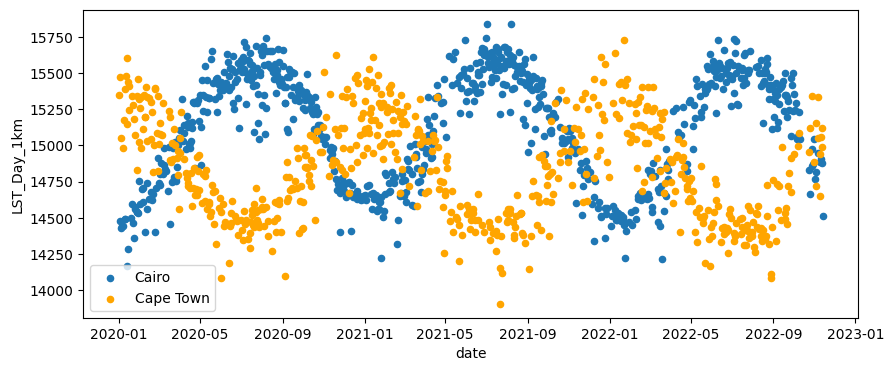

In [ ]:
ax = cairo_lst.plot.scatter(
    x='date',
    y='LST_Day_1km',
    figsize=(10, 4),
    label='Cairo',
)
cape_town_lst.plot.scatter(
    x='date',
    y='LST_Day_1km',
    figsize=(10, 4),
    ax=ax,
    color='orange',
    label='Cape Town',
)
_ = plt.legend()

Notice how the graph illustrates the seasons inversion between the northern (Cairo) and southern (Cape Town) hemispheres.

The plotted temperature above is appears in strange units, This is due to the scaling EE does for precision safety.

## Exercise
Refer to the documentation of [MOD11A1](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1) to determine the scaling factor for `LST_Day_1km` band, apply this factor on the time series data we fetched previously and visualize the result.

**Bonus**: Plot the temperature in celsius (as opposed to Kelvin).

In [ ]:
def _rescale(lst: float):
  if not lst or pd.isna(lst):
    return
  # TODO: Insert Solution here
  pass


cairo_lst['LST_Kelvin'] = cairo_lst['LST_Day_1km'].apply(_rescale)
cape_town_lst['LST_Kelvin'] = cape_town_lst['LST_Day_1km'].apply(_rescale)

if not cairo_lst['LST_Kelvin'].isna().all():
  ax = cairo_lst.plot.scatter(
      x='date',
      y='LST_Kelvin',
      figsize=(10, 4),
      label='Cairo',
  )
  cape_town_lst.plot.scatter(
      x='date',
      y='LST_Kelvin',
      figsize=(10, 4),
      ax=ax,
      color='orange',
      label='Cape Town',
  )
  _ = plt.legend()

In [ ]:
def _kelvin_to_celsius(k: float):
  if not k or pd.isna(k):
    return
  # TODO: Insert Solution here
  pass

cairo_lst['LST_Celsius'] = cairo_lst['LST_Kelvin'].apply(
    _kelvin_to_celsius
)
cape_town_lst['LST_Celsius'] = cape_town_lst['LST_Kelvin'].apply(
    _kelvin_to_celsius
)

if not cairo_lst['LST_Celsius'].isna().all():
  ax = cairo_lst.plot.scatter(
      x='date',
      y='LST_Celsius',
      figsize=(10, 4),
      label='Cairo',
  )
  cape_town_lst.plot.scatter(
      x='date',
      y='LST_Celsius',
      figsize=(10, 4),
      ax=ax,
      color='orange',
      label='Cape Town',
  )
  _ = plt.legend()

In [ ]:
# @title [Uncomment for solution]
# def _rescale_and_convert_to_celsius(lst: float):
#   if not lst or pd.isna(lst):
#     return
#   return 0.02 * lst - 273.15


# cairo_lst['LST_Celsius'] = cairo_lst['LST_Day_1km'].apply(
#     _rescale_and_convert_to_celsius
# )
# cape_town_lst['LST_Celsius'] = cape_town_lst['LST_Day_1km'].apply(
#     _rescale_and_convert_to_celsius
# )

# ax = cairo_lst.plot.scatter(
#     x='date',
#     y='LST_Celsius',
#     figsize=(10, 4),
#     label='Cairo',
# )
# cape_town_lst.plot.scatter(
#     x='date',
#     y='LST_Celsius',
#     figsize=(10, 4),
#     ax=ax,
#     color='orange',
#     label='Cape Town',
# )
# _ = plt.legend()

# Section 3: World population calculation

In this section we want to find the population  over regions. For this we ues the [WorldPop](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop?hl=en#bands) dataset. We'll explore different ways of how to formulate this problem.

In [ ]:
# @title Choose a country to focus on. {run: 'auto'}
selected_country = 'Ghana' #@param ['East Africa', 'West Africa', 'Algeria', 'Angola', 'Austria', 'Belgium', 'Benin', 'Botswana', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Rep.', 'Chad', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Croatia', 'Cyprus', 'Czech Rep.', 'Denmark', 'Djibouti', 'Egypt', 'Eq. Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Germany', 'Ghana', 'Greece', 'Guinea', 'Guinea Bissau', 'Hungary', 'Ireland', 'Italy', 'Ivory Coast', 'Kenya', 'Latvia', 'Lesotho', 'Liberia', 'Libya', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco', 'Mozambique', 'Namibia', 'Netherlands', 'Niger', 'Nigeria', 'Poland', 'Portugal', 'Romania', 'Rwanda', 'S. Sudan', 'Senegal', 'Sierra Leone', 'Slovakia', 'Slovenia', 'Somalia', 'South Africa', 'Spain', 'Sudan', 'Swaziland', 'Sweden', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'United Kingdom', 'Zambia', 'Zimbabwe']
country_code = coco.convert(selected_country, to='ISO3')

In [ ]:
world_pop = ee.ImageCollection("WorldPop/GP/100m/pop")

In [ ]:
image = (
    world_pop.filterDate('2020', '2021')
    .filter(ee.Filter.eq('country', country_code))
    .first()
)
map = _plot_ee_image(
    image,
    f'{selected_country} population map',
    zoom_start=7,
    coords=image.geometry().centroid(1).getInfo()['coordinates'][::-1],
    visParams=WORLD_POP_VISPARAMS,
)
_display_map(map)

You will explore mapping reduction operations over feature collections.
* **Map**: EE makes it easy to compute and abstract operations over over collections using the [`ImageCollection.map`](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-map) method. It maps any funtion *`func`* that takes an `ee.Image` and produce a `ee.Feature` like object.
* **Image.reduceRegions**: Applies a reduction of the image over a list of geometries (represented as `FeatureCollections`).

<img src='https://drive.google.com/uc?id=1LIn7vFANH16H540Uk3p4usvZC8bM86fe'>

## Using a bounding box

As a naive way of counting population, we'll consider a hand drawn boinding box over as a proxy for a region geometry. We'll explore more precise ways of defining region boundaries in the next section.

In [ ]:
# You can use http://bboxfinder.com to draw bounding boxes.
min_lng = -0.450011  # @param {"type": "number"}
min_lat = 5.504414  # @param {"type": "number"}
max_lng = 0.040598  # @param {"type": "number"}
max_lat = 5.801311  # @param {"type": "number"}
bbox = ee.Geometry.BBox(min_lng, min_lat, max_lng, max_lat)

map = _plot_ee_polygons([bbox], 'Accra Bounding Box', zoom_start=10)
map = _plot_ee_image(image, 'WorldPop', visParams=WORLD_POP_VISPARAMS, map=map)
_display_map(map)

In [ ]:
# @title Helper function for parsing the result.
def _parse_reduce_region_result(result):
  properties = [{**f['properties'], 'id': f['id']} for f in result['features']]
  df = pd.DataFrame(properties)
  return df

<Axes: title={'center': 'Approximate population with a Bounding Box.'}, xlabel='year'>

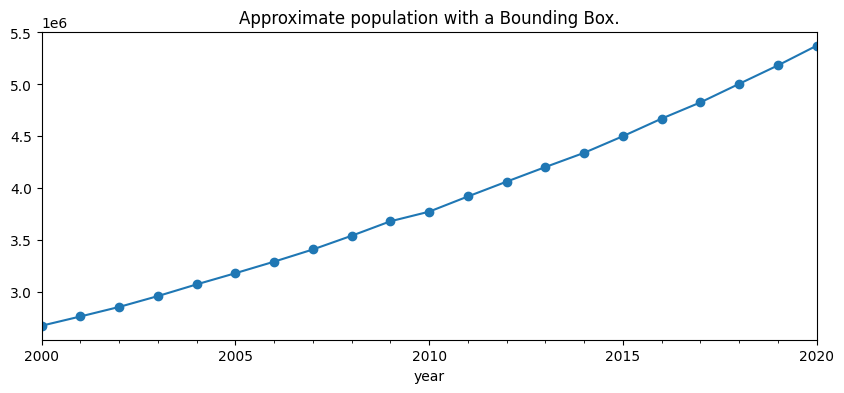

In [ ]:
def _get_sum_over_geometry(
    image: ee.Image, geometry_collection: ee.FeatureCollection
) -> ee.FeatureCollection:
  """Reduces `image` values using `sum` over one or more geometry features.

  Args:
    image: Image to reduce.
    geometry_collection: Collection of polygon-like features (e.g. bbox,
      polygon, multipolygon) to reduce over.

  Returns:
    A feature collection with each feature representing the reduction of `image`
    over the corresponding geometry from `geometry_collection`.
  """
  result = image.reduceRegions(
      geometry_collection,
      ee.Reducer.sum(),
  )
  # Remove the geometry data from the feature to reduce the size of the returned
  # data via `getInfo`.
  result = result.map(lambda f: ee.Feature(None, f.toDictionary()))
  return result


bbox_feature = ee.Feature(bbox)
bbox_population = (
    world_pop.filter(ee.Filter.eq('country', country_code))
    .map(lambda image: _get_sum_over_geometry(image, [bbox_feature]))
    # Since each mapped call returns a feature collection, flatten the
    # collection of collections.
    .flatten()
    .getInfo()
)
bbox_df = _parse_reduce_region_result(bbox_population)
# Parse the year from the id field.
bbox_df['year'] = pd.to_datetime(bbox_df['id'].apply(lambda s: s[4:8]))
bbox_df.set_index('year')['sum'].plot(
    figsize=(10, 4),
    title='Approximate population with a Bounding Box.',
    marker='o',
)

## Using Standard polygons from the FAO.

[FAO GAUL](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level1#table-schema) provide polygons for first level administrative regions worldwide. We'll use these as geometries to reduce over, providing a convenient way of population data extraction that can be done everywhere in the world.
Other polygon datasets
* [FAO GAUL Admin 0](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0): Country level polygons.
* [FAO GAUL Admin 2](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2): Locality level polygons.

In [ ]:
admin_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level1")

In [ ]:
selected_admins = admin_boundaries.filter(
    ee.Filter.eq('ADM0_NAME', selected_country)
)
admins_geometries = [
    ee.Geometry.MultiPolygon(f['geometry']['coordinates'])
    for f in selected_admins.getInfo()['features']
]

In [ ]:
map = _plot_ee_polygons(admins_geometries, name=f'{selected_country} administrative boundaries', zoom_start=7, border_color='Blue', fill_color='cyan')
_display_map(map)

In [ ]:
population_series_by_admin = (
    world_pop.select('population')
    .filter(ee.Filter.eq('country', 'GHA'))
    .filterDate('2005-01-01', '2021-01-01')
    .map(lambda image: _get_sum_over_geometry(image, selected_admins))
    .flatten()
)

In [ ]:
population_series_by_admin = population_series_by_admin.getInfo()
population_df = _parse_reduce_region_result(population_series_by_admin)
# Parse the year from the id field.
population_df['year'] = pd.to_datetime(
    population_df['id'].apply(lambda s: s[4:8])
)

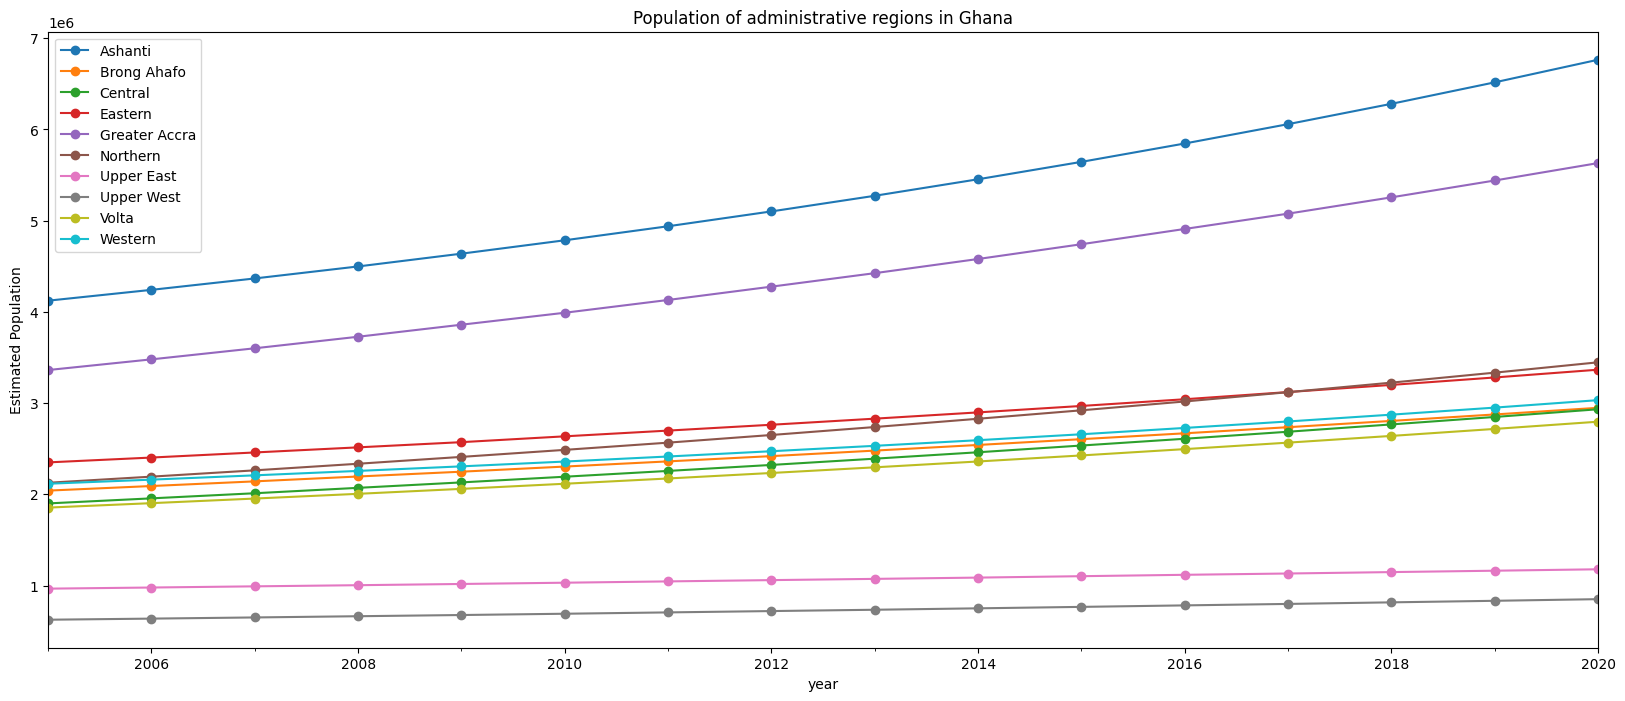

In [ ]:
population_df.set_index('year').groupby('ADM1_NAME')['sum'].plot(
    legend=True,
    figsize=(20, 8),
    ylabel='Estimated Population',
    title=f'Population of administrative regions in {selected_country}',
    marker='o',
)
plt.legend()

### Excersise
Go through this section again but with a different country.

# Section 4: Desertification mapping with Dynamic World

[Dynamic World](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1) is a Sentinel-2 based product that classifies land surface into one of the following classes
1. Water
2. Trees
3. Grass
4. Flooded Vegetation
5. Crops
6. Shrub and Scrub
7. Built land
8. Bare land
9. Snow and Ice

In [ ]:
dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

image = (
    dynamic_world.filterDate('2022-01-01', '2023-01-01')
    .select('label')
    .mosaic()
)
map = _plot_ee_image(
    image,
    name='Dynamic world',
    zoom_start=16,
    coords=(5.6515477, -0.1868334),
    visParams=DYNAMIC_WORLD_VISPARAMS,
)
_display_map(map)

In this section we'll define a simple algorithm to detect desertification between year $i$ and $j$ where $i < j$.
Using dynamic world:
* For each pixel in the world we'll take the `mode` Dynamic World class throughout both year `i` and `j` to get $Mo_i$ and $Mo_j$.
* The pixel is classified as desertification if and only if
 $$Mo_i \in \{trees, grass, crops\}$$ and
 $$Mo_j = bare$$

In [ ]:
YEAR_i = 2015  # @param {"type": "number"}
YEAR_j = 2023  # @param {"type": "number"}
class_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]
DW_PROBABILITY_THRESHOLD = 0.40  # @param {"type": "number"}


def _get_masked_dw_image_for_year(year):
  # First, in order to ensure we have full coverage over the entire world (with
  # sufficient pixels without clouds) we form a full image over the earth by
  # calculating tthe mean
  dw_interval = dynamic_world.filterDate(f"{year}-01-01", f"{year}-12-31")
  mask = (
      dw_interval.select(class_labels)
      .mean()
      .reduce(ee.Reducer.max())
      .gte(DW_PROBABILITY_THRESHOLD)
  )
  dw_image = dw_interval.select("label").mode().mask(mask)
  return dw_image


def _get_sentinel_2_image_for_date(year):
  s2_image = (
      sentinel_2.filterDate(f"{year}-01-01", f"{year}-12-31")
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
      .select(["B4", "B3", "B2"])
      .mosaic()
      .multiply(0.0001)
  )
  return s2_image


dw_i = _get_masked_dw_image_for_year(YEAR_i)
dw_j = _get_masked_dw_image_for_year(YEAR_j)

s2_i = _get_sentinel_2_image_for_date(YEAR_i)
s2_j = _get_sentinel_2_image_for_date(YEAR_j)

In [ ]:
def _is_dw_green(dw_image):
  # trees, grass, crops
  green_labels = [1, 2, 4, 5]

  green_image = dw_image.eq(green_labels[0])
  for other_green_label in green_labels:
    green_image = green_image.Or(dw_image.eq(other_green_label))
  return green_image


green_i = _is_dw_green(dw_i)
bare_j = dw_j.eq(7)
desertification = green_i.And(bare_j).unmask(0)

In [ ]:
map = _plot_ee_image(
    desertification,
    name='Desertification',
    visParams=DESERTIFICATION_VISPARAMS,
    zoom_start=11,
    coords=(18.1008527, 33.9783173),
)
map = _plot_ee_image(s2_i, f'S2 {YEAR_i}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(s2_j, f'S2 {YEAR_j}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(
    dw_i,
    f'Dynamic World {YEAR_i}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)
map = _plot_ee_image(
    dw_j,
    f'Dynamic World {YEAR_j}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)

_display_map(map)

# Further reading

* [EE Community tutorials](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api): These are tutorials made by the GEE users community. It's provides both good introduction to how to use EE with Python and cool geospatial applications at the same time.